## Image Pre-Processing

In [109]:
from pali_gemma.data.image_preprocess import process_images

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_SZE = 224
IMAGE_PATH = "./cat.png"
PROMPT = "Question: What the picture about?"
MODEL_PATH = "./models_weight"

In [111]:
image = Image.open(IMAGE_PATH)
image = image.convert("RGB")

min value: 0 max value: 240


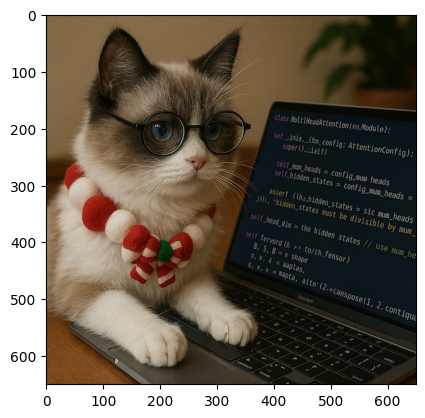

In [112]:
plt.imshow(image)
print("min value:", np.array(image).min(), "max value:", np.array(image).max())

In [113]:
processed_image = process_images(
    [image],
    size=(IMAGE_SZE, IMAGE_SZE),
    resample=Image.Resampling.BICUBIC,
    rescale_factor=1 / 255.0,
)

min value: -1.0 max value: 0.69411767


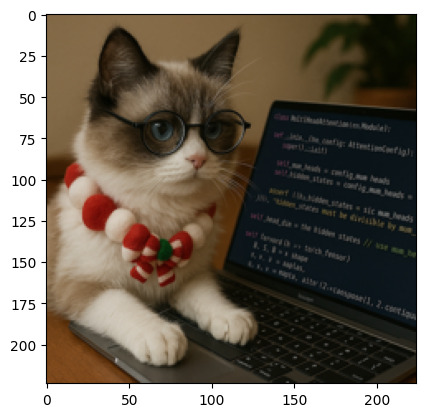

In [114]:
img = processed_image[0]  # (3, 224, 224)
img = img.transpose(1, 2, 0)
print("min value:", img.min(), "max value:", img.max())


img = (img * 0.5) + 0.5
img = img.clip(0, 1)
plt.imshow(img)

## Text Tokenization

In [ ]:
import torch

In [ ]:
from transformers import AutoTokenizer

In [ ]:
PROMPT

In [ ]:
IMAGE_TOKEN = "<image>"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, padding_side="right")

tokenizer.add_bos_token = False
tokenizer.add_eos_token = False
tokens_to_add = {"additional_special_tokens": [IMAGE_TOKEN]}
tokenizer.add_special_tokens(tokens_to_add)

inputs = tokenizer(PROMPT, padding="longest", return_tensors="pt")
EXTRA_TOKENS = [
    f"<loc{i:04d}>" for i in range(1024)
]  # These tokens are used for object detection (bounding boxes)
EXTRA_TOKENS += [
    f"<seg{i:03d}>" for i in range(128)
]  # These tokens are used for object segmentation
tokenizer.add_tokens(EXTRA_TOKENS)

In [ ]:
inputs = tokenizer(PROMPT, padding="longest", return_tensors="pt")
input_ids = inputs.input_ids
input_ids

In [ ]:
tokenizer.decode(input_ids[0], add_special_tokens=False)

In [ ]:
image_token_id = tokenizer.convert_tokens_to_ids(IMAGE_TOKEN)
image_token_id

In [ ]:
attention_mask = inputs.attention_mask
attention_mask

## Concat 

In [ ]:
pixel_values = torch.from_numpy(np.stack(processed_image))
pixel_values.shape

In [ ]:
# Create input text
from pali_gemma.data.paligemma_preprocess import add_image_tokens_to_prompt

In [ ]:
input_strings = [
    add_image_tokens_to_prompt(
        prefix_prompt=prompt,
        bos_token=tokenizer.bos_token,
        image_seq_len=224 * 224 // 16,
        image_token=IMAGE_TOKEN,
    )
    for prompt in [PROMPT]
]

In [ ]:
image_token_id

In [ ]:
224 * 224 // 16

In [ ]:
input_strings[0][-100:]

In [ ]:
inputs = tokenizer(input_strings, return_tensors="pt", padding="longest")

In [ ]:
inputs_ids = inputs.input_ids
inputs_ids.shape

In [ ]:
torch.all(inputs.attention_mask == 1)

In [ ]:
tokenizer.decode(inputs_ids[0], skip_special_tokens=True)

# Test Model

In [ ]:
from pali_gemma.load_weight import load_hf_model

In [ ]:
device = torch.device("mps")

In [ ]:
model, tokenizer = load_hf_model(MODEL_PATH, device)

In [ ]:
model

In [ ]:
inputs_ids.shape

In [ ]:
from pali_gemma.model.kv_cache import KVCache

In [ ]:
input_ids.shape

In [ ]:
pixel_values.shape

In [ ]:
attention_mask.shape

In [ ]:
inputs = tokenizer(input_strings, return_tensors="pt", padding="longest")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
pixel_values = pixel_values.to(device)
attention_mask = attention_mask.to(device)
input_ids = input_ids.to(device)

In [ ]:
input_ids.shape, attention_mask.shape, pixel_values.shape

In [ ]:
import gc

gc.collect()
torch.mps.empty_cache()

kv_cache = KVCache()

out = model(
    input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, kv_cache=kv_cache
)

torch.mps.empty_cache()
gc.collect()

In [ ]:
logits = out["logits"][:, -1, :]

In [ ]:
logits.argmax(dim=-1)

In [ ]:
tokenizer.decode(logits.argmax(dim=-1))

In [ ]:
kv_cache.num_items()

In [ ]:
len(kv_cache.key_cache)

In [ ]:
(attention_mask.cumsum(-1)).masked_fill_((attention_mask == 0), 1)